# Binary classification: offers on the marketplace

##### Задача бинарной классификации по сопоставлению товаров между собой с целью детекции матчей

### Описание задачи

В распоряжении обезличенные данные по товарным предложениям продавцов (предложение) и товарного ассортимента маркетплейса «Мегамаркет» (товары). В данных для каждого предложения найдены самые популярные товары в ассортименте, и указаны основные характеристики этой пары. Необходимо только классифицировать, какой из пар является совпадением, а какой — нет.

##### Метрика
Оценка качества модели будет производиться с использованием метрики **F1**

### Описание данных:

- **train.csv** (тренировочный набор данных)
- **test.csv**(тестовый набор)

##### Columns

- **offer_depersanalised** и **goods_depersanalised** - идентификаторы предложения и товара соответственно
- **sum_length** - суммарная длина пары названий и атрибутов в символах
- **attrs+title_score** - вероятность матча от рескоринговой модели
- **offer_price** и **item_price** - цена предложения и товара соответственно
- **goods_category_id** - категория товара
- **id** - идентификатор пары offer_depersanalised + $ + goods_depersanalised
- **target** (только в train.csv) - метка класса (0 - не матч, 1 - матч)


##### Embeddings

- **goods_image_vectors** и **offer_image_vectors** - содержат файлы с векторами изображений (embed_deperson.npy) и их идентификаторами (items_deperson.npy) для товаров ассортимента и предложений соответсвенно. Объекты в файлах соотносятся 1 к 1
- **goods_title_vectors** и **offer_title_vectors** - содержат файлы с векторами названий+атрибутов (embed_deperson.npy) и их идентификаторами (items_deperson.npy) для товаров ассортимента и предложений соответсвенно. Объекты в файлах соотносятся 1 к 1

# Загрузка необходимых библиотек и датафреймов

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

## Определение значения констант

In [2]:
RANDOM_STATE = 123456
TEST_SIZE = 0.3

## Настройка вывода данных

In [3]:
# Параметры отображения
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)

## Загрузка данных

In [4]:
# Путь к файлу
path_to_dir = ''

In [5]:
sample_submission = pd.read_csv(path_to_dir + 'sample_submission.csv')
test = pd.read_csv(path_to_dir + 'test.csv')
train = pd.read_csv(path_to_dir + 'train.csv')

In [6]:
# Файлы с векторами изображений
goods_image_embed = np.load(path_to_dir + 'goods_image_vectors/embed_deperson.npy')
goods_image_items = np.load(path_to_dir + 'goods_image_vectors/items_deperson.npy')

goods_title_embed = np.load(path_to_dir + 'goods_title_vectors/embed_deperson.npy')
goods_title_items = np.load(path_to_dir + 'goods_title_vectors/items_deperson.npy')

# Файлы с векторами названий+атрибутов и их идентификаторы
offer_image_embed = np.load(path_to_dir + 'offer_image_vectors/embed_deperson.npy')
offer_image_items = np.load(path_to_dir + 'offer_image_vectors/items_deperson.npy')

offer_title_embed = np.load(path_to_dir + 'offer_title_vectors/embed_deperson.npy')
offer_title_items = np.load(path_to_dir + 'offer_title_vectors/items_deperson.npy')


# Изучение общей информации

## Функция обзора данных

In [7]:
def review(data):

    print('\033[1m \nОбщая информация: \n\033[0m \n')
    data.info()
    display(data.head(2))
    display(data.tail(2))

    print('\n\033[1m Пропуски в данных: \033[0m \n')
    display(data.isna().sum())
    print('\n\033[1m Всего пропущенных значений: \033[0m', data.isna().sum().sum())
    print('\n\033[1m Количество явных дублей: \033[0m', data.duplicated().sum())
    
    print('\n\033[1m Основные статистические характеристики данных: \033[0m')
    display(data.describe(include='all'))

## Тренировочный набор данных

In [8]:
review(train)

 
Общая информация: 
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518441 entries, 0 to 2518440
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   offer_depersanalised  int64  
 1   goods_depersanalised  int64  
 2   sum_length            int64  
 3   attrs+title_score     float64
 4   offer_price           int64  
 5   goods_price           float64
 6   goods_category_id     float64
 7   target                int64  
 8   id                    object 
dtypes: float64(3), int64(5), object(1)
memory usage: 172.9+ MB


,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
0,295140,1396793,37,0.03,1070,NaN,14.00,0,295140$1396793
1,65291,1396586,38,0.05,698,NaN,14.00,0,65291$1396586


,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
2518439,340842,1163356,7597,0.00,717,313.00,2463684633817211.00,0,340842$1163356
2518440,189980,1163346,7829,0.00,898,698.00,2463684633817211.00,0,189980$1163346



 Пропуски в данных:  



offer_depersanalised         0
goods_depersanalised         0
sum_length                   0
attrs+title_score            0
offer_price                  0
goods_price             407287
goods_category_id          833
target                       0
id                           0
dtype: int64


 Всего пропущенных значений:  408120

 Количество явных дублей:  0

 Основные статистические характеристики данных: 


,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
count,2518441.00,2518441.00,2518441.00,2518441.00,2518441.00,2111154.00,2517608.00,2518441.00,2518441
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500000
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,391912$1392831
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
mean,286190.56,876165.67,587.07,0.13,936296.11,47984.29,4873335911078.39,0.12,NaN
std,165331.39,512291.30,426.58,0.26,9569628.73,7939301.64,109465145852502.12,0.32,NaN
min,0.00,0.00,37.00,0.00,101.00,101.00,2.00,0.00,NaN
25%,142953.00,423465.00,231.00,0.00,990.00,665.00,5.00,0.00,NaN
50%,286441.00,870836.00,507.00,0.00,2838.00,1780.00,6.00,0.00,NaN
75%,429243.00,1307631.00,807.00,0.05,9300.00,6516.00,14.00,0.00,NaN


Максимальные значения обоих параметров(offer_price и goods_price) значительно превышают 75-перцентиль, что указывает на наличие **выбросов** в данных, из-за чего стандартное отклонение **не информативно**, сами данные могут быть искажены. **Средние** значения **цены предложения** (offer_price) и **цены товара** (goods_price) значительно **различаются**.

## Тестовый набор данных

In [9]:
review(test)

 
Общая информация: 
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363835 entries, 0 to 363834
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   offer_depersanalised  363835 non-null  int64  
 1   goods_depersanalised  363835 non-null  int64  
 2   sum_length            363835 non-null  int64  
 3   attrs+title_score     363835 non-null  float64
 4   offer_price           363835 non-null  int64  
 5   goods_price           304864 non-null  float64
 6   goods_category_id     363704 non-null  float64
 7   id                    363835 non-null  object 
dtypes: float64(3), int64(4), object(1)
memory usage: 22.2+ MB


,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,id
0,64819,1396468,38,0.05,368,NaN,14.00,64819$1396468
1,64819,1396235,38,0.05,368,NaN,14.00,64819$1396235


,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,id
363833,24514,130142,5760,0.00,2000,259.00,2463684633817211.00,24514$130142
363834,63490,1146634,6175,0.00,915,1304.00,2463684633817211.00,63490$1146634



 Пропуски в данных:  



offer_depersanalised        0
goods_depersanalised        0
sum_length                  0
attrs+title_score           0
offer_price                 0
goods_price             58971
goods_category_id         131
id                          0
dtype: int64


 Всего пропущенных значений:  59102

 Количество явных дублей:  0

 Основные статистические характеристики данных: 


,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,id
count,363835.00,363835.00,363835.00,363835.00,363835.00,304864.00,363704.00,363835
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,363835
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,411013$802722
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,286850.60,877114.67,583.42,0.13,958357.69,30895.12,5100726220411.27,NaN
std,165256.36,511892.47,423.87,0.26,9683426.36,5866152.16,111984810946494.66,NaN
min,1.00,18.00,38.00,0.00,101.00,101.00,2.00,NaN
25%,144092.00,424936.50,231.00,0.00,982.00,663.00,5.00,NaN
50%,286456.00,870778.00,504.00,0.00,2832.00,1770.00,6.00,NaN
75%,429787.00,1307888.50,800.00,0.05,9321.00,6550.00,14.00,NaN


Из предоставленных данных видно, что **цена** предложений значительно **выше**, чем цены самих товаров.
**Чаще** всего встречается товар категории **14**. Суммарная длина пары названий и атрибутов в символах в среднем достиграет **583** со стандартным отклонением **424**

В данных так же есть **аномалии**

## Sample submission

In [10]:
review(sample_submission)

 
Общая информация: 
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363835 entries, 0 to 363834
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      363835 non-null  object
 1   target  363835 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.6+ MB


,id,target
0,64819$1396468,1
1,64819$1396235,1


,id,target
363833,24514$130142,0
363834,63490$1146634,0



 Пропуски в данных:  



id        0
target    0
dtype: int64


 Всего пропущенных значений:  0

 Количество явных дублей:  0

 Основные статистические характеристики данных: 


,id,target
count,363835,363835.00
unique,363835,NaN
top,411013$802722,NaN
freq,1,NaN
mean,NaN,0.50
std,NaN,0.50
min,NaN,0.00
25%,NaN,0.00
50%,NaN,0.00
75%,NaN,1.00


## Подсчет уникальных значений

In [11]:
for i in train.columns:
    print('\n\033[1m Значения признака: \033[0m', i)
    print(train[i].value_counts())


 Значения признака:  offer_depersanalised
399586    10
24061     10
417588    10
503562    10
518       10
          ..
10235      5
8188       5
6141       5
4094       5
2047       5
Name: offer_depersanalised, Length: 500000, dtype: int64

 Значения признака:  goods_depersanalised
857565    7179
857566    6909
766583    3282
857616    3204
857619    2835
          ... 
79833        1
75739        1
108491       1
106444       1
104397       1
Name: goods_depersanalised, Length: 1592607, dtype: int64

 Значения признака:  sum_length
209     5534
211     5465
220     5437
212     5402
214     5382
        ... 
3466       1
3471       1
4035       1
5757       1
3724       1
Name: sum_length, Length: 3208, dtype: int64

 Значения признака:  attrs+title_score
0.00    74779
0.00    74683
0.00    73644
0.00    73345
0.00    68876
        ...  
1.00       17
1.00        8
1.00        4
0.00        4
0.00        1
Name: attrs+title_score, Length: 5306, dtype: int64

 Значения признака:  of

**График распределения целевого признака**

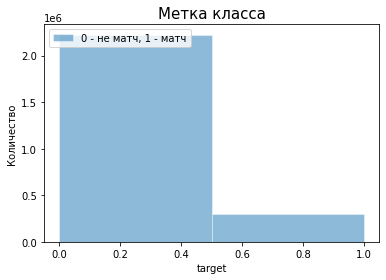

In [12]:
plt.rc('axes', titlesize=15)  

sns.histplot(train['target'], bins=(2), alpha = 0.5, 
             edgecolor=(1, 1, 1, .4), label='0 - не матч, 1 - матч')
    
plt.legend(loc='upper left')
plt.ylabel('Количество')
plt.title('Mетка класса')
plt.show()

Наблюдается сильный **дисбаланс** с перекосом в сторону нулевой метки. Это нужно будет учитывать при обучении моделей 

Идентификатор пары **offer_depersanalised + $ + goods_depersanalised** можно **удалить** из тренировочной выборки, не понадобится для обучения

In [13]:
train.drop(columns='id', inplace=True)

# Предобработка данных

## Функции для анализа данных

In [14]:
# Пропуски и корреляция между ними
def missing_data(data):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    
    msno.matrix(data, ax=axes[0], sparkline=False)
    axes[0].set_title('The matrix of zero values', fontsize=16)
    
    msno.heatmap(data, ax=axes[1])
    axes[1].set_title('Correlation of zero values', fontsize=16)
    
    plt.tight_layout()
    plt.show()

In [15]:
# Ящик с усами 
def boxplot_features(data):
    for column in data.columns:
        plt.figure(figsize=(12, 2))
        sns.boxplot(data[column], orient="h", color='skyblue')
        plt.title(column, fontsize=16)
        plt.show()

## Пропуски

#### train

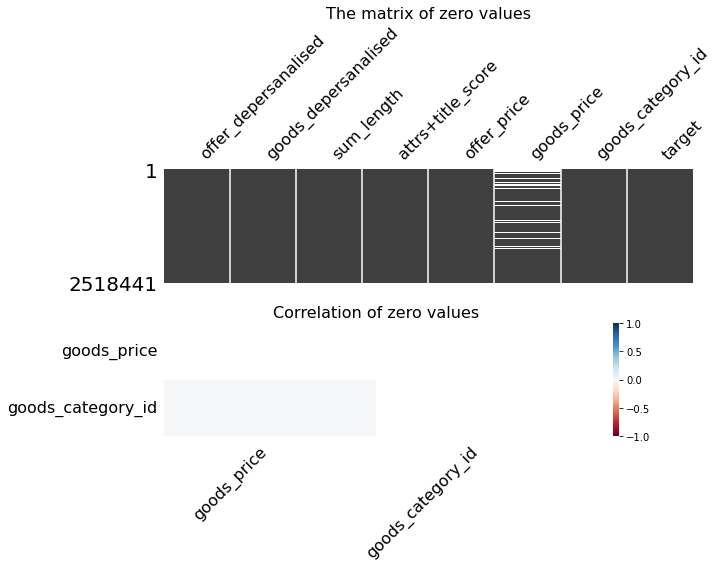

In [16]:
missing_data(train)

#### test

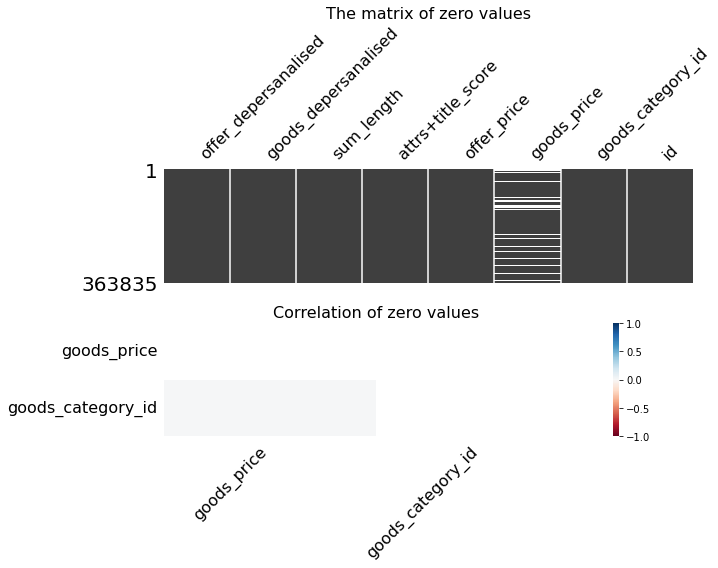

In [17]:
missing_data(test)

В данных нет корреляции между пропусками, в обоих случаях

Поставим заглушку в `goods_category_id`

In [18]:
train['goods_category_id'] = train['goods_category_id'].fillna(-1)
test['goods_category_id'] = test['goods_category_id'].fillna(-1)

Заполним пропуски в `goods_price` медианой по столбцу `goods_category_id`

In [19]:
train['goods_price'] = train['goods_price'].fillna(train.groupby(['goods_category_id']
                                                               )['goods_price'].transform('median'))

test['goods_price'] = test['goods_price'].fillna(test.groupby(['goods_category_id']
                                                               )['goods_price'].transform('median'))

Если остались не заполненные строки, удалим их

In [20]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [21]:
train.isna().sum()

offer_depersanalised    0
goods_depersanalised    0
sum_length              0
attrs+title_score       0
offer_price             0
goods_price             0
goods_category_id       0
target                  0
dtype: int64

In [22]:
test.isna().sum()

offer_depersanalised    0
goods_depersanalised    0
sum_length              0
attrs+title_score       0
offer_price             0
goods_price             0
goods_category_id       0
id                      0
dtype: int64

## Распределение данных

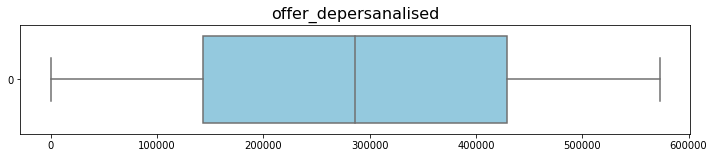

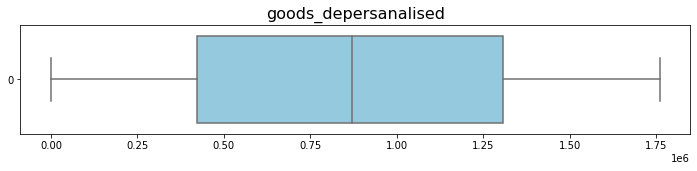

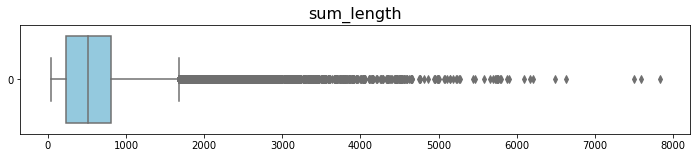

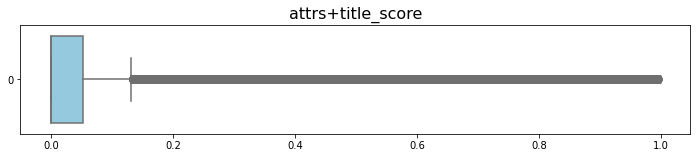

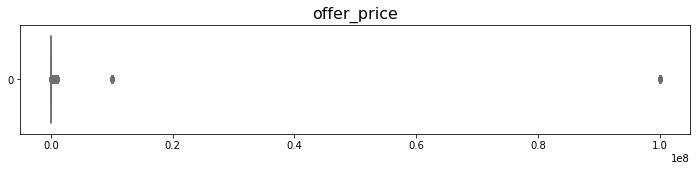

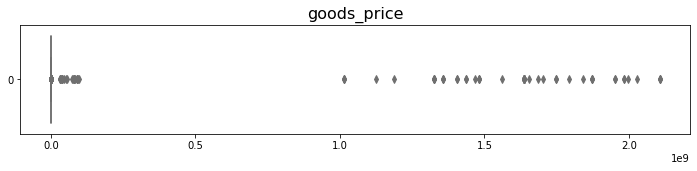

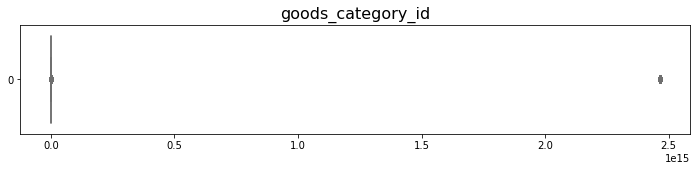

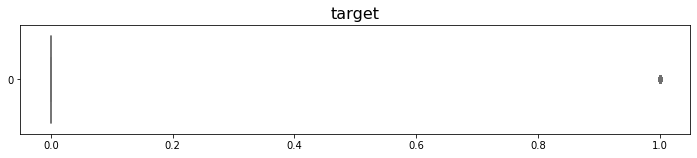

In [23]:
boxplot_features(train)

Как и было выявлено ранее, в **offer_price** и **goods_price** встречаются редкие выбивающиеся значения, эти строки можно удалить

In [24]:
train.drop(train[train['offer_price'] >= 100000].index, inplace=True)
train.drop(train[train['goods_price'] >= 100000].index, inplace=True)

In [25]:
train[['offer_price', 'goods_price']].describe(include='all')

,offer_price,goods_price
count,2439501.00,2439501.00
mean,8496.64,6106.63
std,14772.50,12041.55
min,101.00,101.00
25%,959.00,693.00
50%,2689.00,1965.00
75%,8150.00,4931.00
max,99999.00,99999.00


Данные в оставшихся признаках, хранят допустимые значения

## Новые признаки

- Абсолютная разница: Разница между offer_price и goods_price в абсолютных значениях.
- Вычисление отношения между ценой предложения (offer_price) и ценой товара (goods_price).

In [26]:
train['difference'] = abs(train['offer_price'] - train['goods_price'])
train['price_ratio'] = train['offer_price'] / train['goods_price']

In [27]:
train.head()

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,difference,price_ratio
0,295140,1396793,37,0.03,1070,578.00,14.00,0,492.00,1.85
1,65291,1396586,38,0.05,698,578.00,14.00,0,120.00,1.21
2,39232,1396244,38,0.09,837,578.00,14.00,0,259.00,1.45
3,39232,1396513,38,0.09,837,578.00,14.00,0,259.00,1.45
4,65052,1396237,38,0.08,1085,578.00,14.00,0,507.00,1.88


## Обзор данных

In [28]:
# Разделим данные по таргету
train_0 = train.loc[train['target'] == 0]
train_1 = train.loc[train['target'] == 1]

# Список всех численных признаков
num_col = ['sum_length', 'attrs+title_score', 
           'offer_price', 'goods_price', 
           'difference', 'price_ratio']

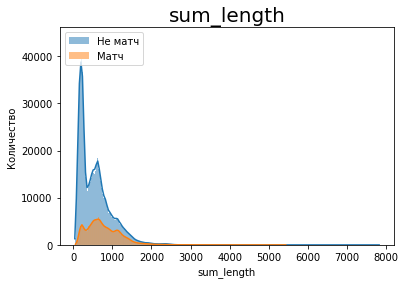

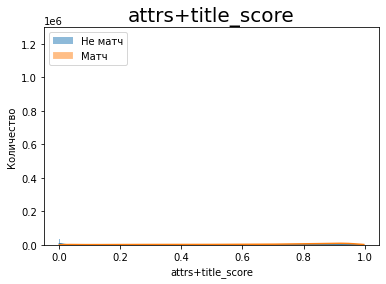

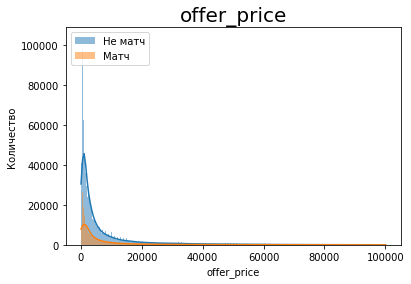

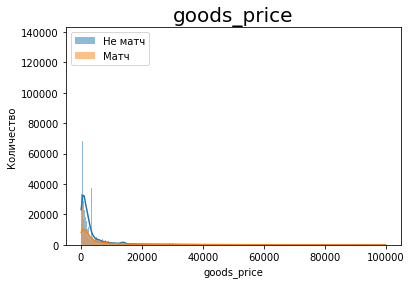

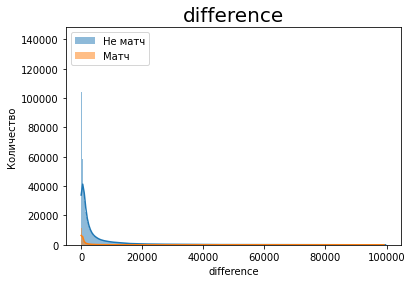

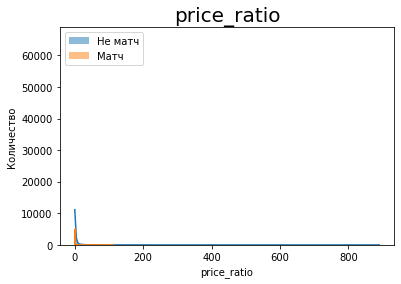

In [29]:
# Гистограмма для численных признаков
for i in num_col:
        
    plt.rc('axes', titlesize=20) 
    
    sns.histplot(train_0[i], kde=True, alpha = 0.5, 
                 edgecolor=(1, 1, 1, .4), label='Не матч')
    
    sns.histplot(train_1[i], kde=True, alpha = 0.5, 
                 edgecolor=(1, 1, 1, .4), label='Матч')
    
    plt.legend(loc='upper left')
    plt.ylabel('Количество')
    plt.title(i)
    plt.show()

## ИТОГ

**Выбросы в данных**, для сглаживания шума, все значения в столбцах `offer_price` и `goods_price` превышающие порог в 100_000 были удалены.

**Пропуски** были изучены с помощью библиотеки `msno`, корреляции между пропусками нет, часть данных были заполнены заглушкой, часть медианой по группам соответствующих столбцов.

**Сгенерированные признаки:**
- **Абсолютная разница** Разница между offer_price и goods_price
- **Отношения между ценой** предложения и ценой товара.

# Эмбеддинги

У нас есть файлы с векторами изображений и названий+атрибутов с идентификаторами. Можно добавить их в основной датасет для обучения модели, для этого:

- Нужно уменьшить размерность эмбеддингов, для этого воспользуемся методом главных компонент PCA
- Объединим векторы с их идентификаторами
- По итогу должны получится двумерные массивы даных, их уже преобразуем в формат DataFrame и смаржим с основным датафреймом

In [30]:
# Делаем копию датасета
train_new = train.copy

Уменьшим размерность эмбеддингов до 20 гланых компонент, но перед этим стандартизируем их

In [31]:
# Инициализация и применение стандартизатора к каждому набору эмбеддингов
scaler = StandardScaler()

# Векторы названий+атрибутов
goods_title_embed = scaler.fit_transform(goods_title_embed)
offer_title_embed = scaler.transform(offer_title_embed)

# Векторы изображений
goods_image_embed = scaler.fit_transform(goods_image_embed)
offer_image_embed = scaler.transform(offer_image_embed)

In [32]:
pca = PCA(n_components=20)

# Векторы названий+атрибутов
goods_title_embed = pca.fit_transform(goods_title_embed)
offer_title_embed = pca.transform(offer_title_embed)

In [33]:
# Векторы изображений
goods_image_embed = pca.fit_transform(goods_image_embed)
offer_image_embed = pca.transform(offer_image_embed)

Объединим векторы изображений с их идентификаторами

In [34]:
# Векторы названий+атрибутов
goods_title = np.column_stack((goods_title_items, goods_title_embed))
offer_title = np.column_stack((offer_title_items, offer_title_embed))

In [35]:
# Векторы изображений
goods_image = np.column_stack((goods_image_items, goods_image_embed))
offer_image = np.column_stack((offer_image_items, offer_image_embed))

Переведем их в формат DataFrame

In [36]:
goods_title = pd.DataFrame(goods_title)
offer_title = pd.DataFrame(offer_title)

goods_image = pd.DataFrame(goods_image)
offer_image = pd.DataFrame(offer_image)

In [37]:
# Объединяем offer_image и goods_image по столбцу 0
df_offer = pd.merge(offer_image, offer_title, on=0, suffixes=('_image_offer', '_title_offer'))

# Объединяем offer_title и goods_title по столбцу 0
df_goods = pd.merge(goods_image, goods_title, on=0, suffixes=('_image_goods', '_title_goods'))

Первый столбец хранит идентификаторы, зададим название:

In [38]:
df_offer = df_offer.rename(columns={df_goods.columns[0]: 'offer_depersanalised'})
df_goods = df_goods.rename(columns={df_goods.columns[0]: 'goods_depersanalised'})

Переведем идентификаторы в нужный тип данных с object в int

In [39]:
df_offer['offer_depersanalised'] = df_offer['offer_depersanalised'].astype(int)
df_goods['goods_depersanalised'] = df_goods['goods_depersanalised'].astype(int)

Сцепим `train` с эмбеддингами

In [40]:
train = pd.merge(df_goods, train, on='goods_depersanalised', how='inner')
train = pd.merge(df_offer, train, on='offer_depersanalised', how='inner')

**Проверим дубли**

In [41]:
train.drop_duplicates(inplace=True)
train.duplicated().sum()

0

In [42]:
# Выгрузка
train.to_csv('train_emb.csv')

In [43]:
train.head()

,offer_depersanalised,1_image_offer,2_image_offer,3_image_offer,4_image_offer,5_image_offer,6_image_offer,7_image_offer,8_image_offer,9_image_offer,10_image_offer,11_image_offer,12_image_offer,13_image_offer,14_image_offer,15_image_offer,16_image_offer,17_image_offer,18_image_offer,19_image_offer,20_image_offer,1_title_offer,2_title_offer,3_title_offer,4_title_offer,5_title_offer,6_title_offer,7_title_offer,8_title_offer,9_title_offer,10_title_offer,11_title_offer,12_title_offer,13_title_offer,14_title_offer,15_title_offer,16_title_offer,17_title_offer,18_title_offer,19_title_offer,20_title_offer,goods_depersanalised,1_image_goods,2_image_goods,3_image_goods,4_image_goods,5_image_goods,6_image_goods,7_image_goods,8_image_goods,9_image_goods,10_image_goods,11_image_goods,12_image_goods,13_image_goods,14_image_goods,15_image_goods,16_image_goods,17_image_goods,18_image_goods,19_image_goods,20_image_goods,1_title_goods,2_title_goods,3_title_goods,4_title_goods,5_title_goods,6_title_goods,7_title_goods,8_title_goods,9_title_goods,10_title_goods,11_title_goods,12_title_goods,13_title_goods,14_title_goods,15_title_goods,16_title_goods,17_title_goods,18_title_goods,19_title_goods,20_title_goods,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,difference,price_ratio
0,206,2.459684,2.0333705,-2.15342,-1.9531354,-1.5502602,0.4773374,1.5758542,0.111208156,-1.4590214,-3.7468724,-1.0664066,-0.52251124,0.27266583,1.0497209,0.47035435,-1.8075706,0.067405455,-2.7935052,2.3493388,-0.26545385,-0.3878830158656558,1.9044972936171831,0.5056816066695108,-0.9442945680588829,1.6971009754524917,0.4090249519991355,-1.4673413629772774,-0.5056815958210994,0.2896054424997721,-0.03233320090846529,-0.9512857418682575,0.650258974701912,1.2983854327698425,1.1890561851343453,1.0099736815052909,-0.7832588448766675,-0.0029072189194727515,0.049177616491258916,-1.0679587773976735,-1.325668668301797,634545,0.4928074,1.0240449,-2.0250194,-2.6193435,-1.6541759,-0.90821695,1.8607503,1.0576857,-1.255598,-0.7790325,-1.0431384,0.5204499,-1.7797014,1.451368,0.20613135,-0.41353878,-0.50848836,-1.4780515,-0.007988067,1.1042429,-0.5653165387709738,1.3900346274881432,1.0312373948950473,0.7286039956767609,-0.09803822632062194,0.3364488073829911,0.7316054446770403,-0.6724174906415714,0.9839886826407003,-0.04132839943338788,0.4889116103925895,0.3605181493200347,-0.6803309191821575,-1.855927732034519,0.544961495772344,0.6675252312845125,1.1971657904379573,-0.8017701243406684,-1.3019559282627382,-0.4521349765477918,1195,0.88,28799,15525.00,3.00,1,13274.00,1.86
1,206,2.459684,2.0333705,-2.15342,-1.9531354,-1.5502602,0.4773374,1.5758542,0.111208156,-1.4590214,-3.7468724,-1.0664066,-0.52251124,0.27266583,1.0497209,0.47035435,-1.8075706,0.067405455,-2.7935052,2.3493388,-0.26545385,-0.3878830158656558,1.9044972936171831,0.5056816066695108,-0.9442945680588829,1.6971009754524917,0.4090249519991355,-1.4673413629772774,-0.5056815958210994,0.2896054424997721,-0.03233320090846529,-0.9512857418682575,0.650258974701912,1.2983854327698425,1.1890561851343453,1.0099736815052909,-0.7832588448766675,-0.0029072189194727515,0.049177616491258916,-1.0679587773976735,-1.325668668301797,634543,0.4928074,1.0240449,-2.0250194,-2.6193435,-1.6541759,-0.90821695,1.8607503,1.0576857,-1.255598,-0.7790325,-1.0431384,0.5204499,-1.7797014,1.451368,0.20613135,-0.41353878,-0.50848836,-1.4780515,-0.007988067,1.1042429,-0.2682997421725136,-1.661638181891044,0.9532434318439609,-0.24491751637916917,0.666050022090358,-1.0142509653735354,0.6885503774854169,-0.015222041848315732,0.17869809347739396,-0.23141653988436392,-0.4097138708019194,-0.9014653250166297,-0.9805552462464647,0.3940310654303062,0.6055323722077153,-0.6304665900431902,-1.3073320690928358,0.9658715968026671,0.24401398391448728,0.4374378117372806,1195,0.00,28799,10897.00,3.00,0,17902.00,2.64
2,206,2.459684,2.0333705,-2.15342,-1.9531354,-1.5502602,0.4773374,1.5758542,0.111208156,-1.4590214,-3.7468724,-1.0664066,-0.52251124,0.27266

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 432637 entries, 0 to 433357
Data columns (total 90 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   offer_depersanalised  432637 non-null  int64  
 1   1_image_offer         432637 non-null  object 
 2   2_image_offer         432637 non-null  object 
 3   3_image_offer         432637 non-null  object 
 4   4_image_offer         432637 non-null  object 
 5   5_image_offer         432637 non-null  object 
 6   6_image_offer         432637 non-null  object 
 7   7_image_offer         432637 non-null  object 
 8   8_image_offer         432637 non-null  object 
 9   9_image_offer         432637 non-null  object 
 10  10_image_offer        432637 non-null  object 
 11  11_image_offer        432637 non-null  object 
 12  12_image_offer        432637 non-null  object 
 13  13_image_offer        432637 non-null  object 
 14  14_image_offer        432637 non-null  object 
 15  

## ИТОГ

На этапе работы с векторами, была уменьшена размерность эмбеддингов с применением метода главных компонент`PCA(n_components=20)`. Получившийся двумерный массив был объединен с итоговым датафреймом 

# Обучение

In [45]:
features = train.drop(['target'], axis=1)
target = train['target']

X_test = test.drop(['id'], axis=1)

# Деление на выборки
X_train, X_valid, y_train, y_valid = train_test_split(
    features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=target)

In [46]:
%%time

pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(verbose=0, 
                                              max_depth=7, 
                                              n_estimators=150))
])

params = {
    #'classifier__n_estimators': [50, 100, 200],
    #'classifier__learning_rate': [0.01, 0.1, 1],
    #'classifier__max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(pipeline, 
                           params, 
                           scoring='f1',
                           cv=5, 
                           error_score='raise', 
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f'best_score: {grid_search.best_score_}')
print(f'best_params: {grid_search.best_params_}')

best_score: 0.9222813853955785
best_params: {}
CPU times: user 1h 31min 30s, sys: 1min 24s, total: 1h 32min 55s
Wall time: 3h 31min 52s


In [47]:
y_pred = grid_search.predict(X_valid)
f1 = f1_score(y_valid, y_pred)

print("F1 на валидационном наборе данных:", f1)

F1 на валидационном наборе данных: 0.9222478509929417


In [48]:
def error_matrix(model, X, y):

    # Предсказания модели
    y_pred = model.predict(X)

    # Построение матрицы ошибок
    cm = confusion_matrix(y, y_pred)

    # Отображение матрицы ошибок в виде тепловой карты
    plt.figure(figsize = (8, 6))
    plt.title('Error matrix')

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

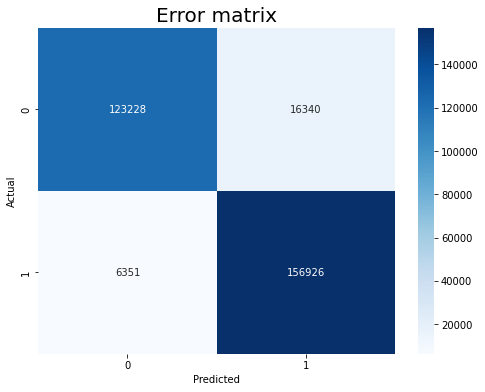

In [49]:
error_matrix(grid_search, X_train, y_train)

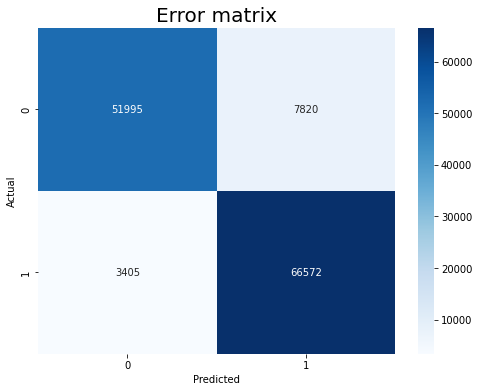

In [50]:
error_matrix(grid_search, X_valid, y_valid)

*На данных без эмбеддингов и без дополнительных признаков метрика достигала 0.74*

# Адекватность модели

In [55]:
dummy_model = DummyClassifier(strategy='stratified')
dummy_model.fit(X_train, y_train)
dummy_pred = dummy_model.predict(X_valid)

f1_dummy = f1_score(y_valid, dummy_pred)
f1_ada = f1_score(y_valid, y_pred)

print("F1 фиктивной модели: %0.2f" % f1_dummy)
print("F1 итоговой модели: %0.2f" % f1_ada)

F1 фиктивной модели: 0.54
F1 итоговой модели: 0.92


**Итоговая** модель намного **лучше фиктивной**, и может быть использована для прогнозирования

# Отчет

**Заказчик:** Разработчики ИТ-решений для ритейла `Samokat.Tech`.


**Цель:** По данным товарных предложений продавцов (предложение) и товарного ассортимента маркетплейса «Мегамаркет» (товары), классифицировать, какой из пар является совпадением, а какой — нет.


**Метрика:** Оценка качества модели будет производиться с использованием метрики F1.

Итоговый датасет был сформирован следующий образом:

- Все значения в столбцах `offer_price` и `goods_price` превышающие порог в 100_000, для **сглаживания шума**,  были удалены.
- **Пропуски** были изучены с помощью библиотеки `msno`, корреляции между пропусками нет, часть данных были заполнены заглушкой, часть медианой по группам соответствующих столбцов.
- На этапе работы **c векторами**, была **уменьшена размерность** эмбеддингов до 20, с применением метода главных компонент. Получившийся двумерный массив был объединен с итоговым датафреймом.

**Сгенерированные признаки:**
```python
- 'difference' - абсолютная разница между offer_price и goods_price
- 'price_ratio' - отношение между ценой предложения и ценой товара
```
**Итоговые признаки**
```python
- 'sum_length' - суммарная длина пары названий и атрибутов в символах
- 'attrs+title_score' - вероятность матча от рескоринговой модели
- 'offer_price' и 'item_price' - цена предложения и товара соответственно
- 'goods_category_id' - категория товара
- 'id' - идентификатор пары offer_depersanalised + $ + goods_depersanalised
- 'difference' - абсолютная разница между offer_price и goods_price
- 'price_ratio' - отношение между ценой предложения и ценой товара
- '_image_offer' и '_image_goods' - эмбеддинги изображений
- '_title_offer' и '_title_goods' - эмбеддинги названий+атрибутов
- 'target' - метка класса (0 - не матч, 1 - матч)
```

**Размер тестовой выборки:**

```python
test_size=.3 
```
**Параметр random_state:**
```python
random_state=123456
```

**Разделены на стратифицированные подгруппы**
```python
stratify=target 
```
**Модель:**
```python
- GradientBoostingClassifier(verbose=0, 
                             max_depth=7, 
                             n_estimators=150)
```
**Значение:** 0.92

*На данных без эмбеддингов и без дополнительных признаков метрика достигала 0.74*

**Адекватность модели**

```python
F1 фиктивной модели: .54
F1 адаптивного бустинга: .92
```
**Трудности в работе:** Возникли сложности с обучением моделей на локальных ресурсах из-за недостаточной вычислительной мощности, что замедляло процесс и требовало значительного времени.